## MARBL O2 and NO3 for ocean history files, box region averages: 

### Case: g.e30_a07c_cesm.GW1850MARBL_JRA.TL319_t232_wgx3_hycom1_N75.2025.134 vs 136 to see if backscatter should be used 


In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import utils
import pandas as pd
import pop_tools
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

### Define case

In [2]:
case_ctrl = 'b.e30_a08a.B1850C_LTso_MARBL.ne30_t232_wgx3.001'
case_test = 'b.e30_a08a.B1850C_LTso_MARBL.ne30_t232_wgx3.002'
user = 'klindsay'

## Define the year range to examine and get the CESM history files

In [3]:
start_yr = 19
num_years = 2
endyr = start_yr + num_years 

#### get the 3-D variables

In [4]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/derecho/scratch/{user}/archive/{case_ctrl}/ocn/hist/{case_ctrl}.mom6.h.bgc.z.{yr4}-{mo2}.nc')))
        
cesm_mon_ds_ctrl = xr.open_mfdataset(files,decode_times=True,decode_coords=False, concat_dim='time')

doing simulation year 19 !
doing simulation year 20 !


In [5]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/derecho/scratch/{user}/archive/{case_test}/ocn/hist/{case_test}.mom6.h.bgc.z.{yr4}-{mo2}.nc')))
        
cesm_mon_ds_test = xr.open_mfdataset(files,decode_times=True,decode_coords=False, concat_dim='time')

doing simulation year 19 !
doing simulation year 20 !


### Keep only the variables we need (use this list for both 2-D and 3-D datasets)

In [6]:
variables3d = ['NO3','O2'] 

coords = {'x':'yh','y':'xh'}

In [7]:
keepthese=['z_l','z_i','time_bounds','time','average_T1', 'average_T2','average_DT'] + variables3d + list(coords.values())
cesm_mon_ds_ctrl = cesm_mon_ds_ctrl.drop([v for v in cesm_mon_ds_ctrl.variables if v not in keepthese])


keepthese=['z_l','z_i','time_bounds','time','average_T1', 'average_T2','average_DT'] + variables3d + list(coords.values())
cesm_mon_ds_test = cesm_mon_ds_test.drop([v for v in cesm_mon_ds_test.variables if v not in keepthese])

## Get the grid data for MOM6

In [8]:
ds_grid = xr.open_dataset(f'/glade/work/kristenk/cesm_work/mom6_static_files/g.e23b16.TL319_t232.GIAFMARBL.001.mom6.h.static.nc')

In [9]:
lons = ds_grid.geolon
lats = ds_grid.geolat
area = ds_grid.areacello #m2
lons_norm = utils.normal_lons(lons)
xlen = len(ds_grid.xh)
ylen = len(ds_grid.yh)

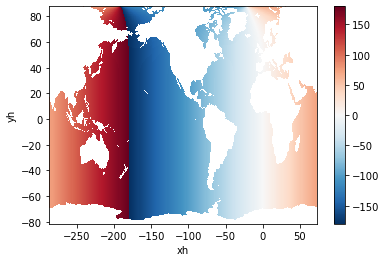

In [10]:
lons_norm.where(ds_grid.wet>0).plot()

#### Make my own dz variable

In [11]:
dz = np.zeros([34])

i = 0

for int in cesm_mon_ds_ctrl.z_i.values[1:35]:
    
    level_up = cesm_mon_ds_ctrl.z_i.values[i]
    #print(level_up,int)
    dz[i] = int - level_up

    i = i + 1

dz = xr.DataArray(dz,dims=('z_l'))

### spin up a bit of dask

In [12]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='25 GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=25GB',
        project='NCGD0011',
        walltime='03:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [13]:
# cluster, client = get_ClusterClient()
# cluster.scale(12) 
# client

### Make the annual mean

In [14]:
cesm_ann_ds_ctrl = cesm_mon_ds_ctrl.mean(dim='time', keep_attrs=True).compute()
cesm_ann_ds_test = cesm_mon_ds_test.mean(dim='time', keep_attrs=True).compute()

### Read in WOA O2 nd NO3

In [15]:
ds_woa = xr.open_dataset('/glade/work/kristenk/WOA_data/regrid_MOM6_2_3/WOA_nuts_O2_mom6grid.nc')

ds_woa['n_an'] = ds_woa['n_an'] * 1.026
ds_woa['n_an'].attrs['units'] = 'mmol/m3'
ds_woa['p_an'] = ds_woa['p_an'] * 1.026
ds_woa['p_an'].attrs['units'] = 'mmol/m3'
ds_woa['o_an'] = ds_woa['o_an'] * 1.026
ds_woa['o_an'].attrs['units'] = 'mmol/m3'
ds_woa['i_an'] = ds_woa['i_an'] * 1.026
ds_woa['i_an'].attrs['units'] = 'mmol/m3'

In [16]:
NO3_diff_ctrl = cesm_ann_ds_ctrl.NO3 - ds_woa.n_an
O2_diff_ctrl = cesm_ann_ds_ctrl.O2 - ds_woa.o_an

NO3_diff_test = cesm_ann_ds_test.NO3 - ds_woa.n_an
O2_diff_test = cesm_ann_ds_test.O2 - ds_woa.o_an

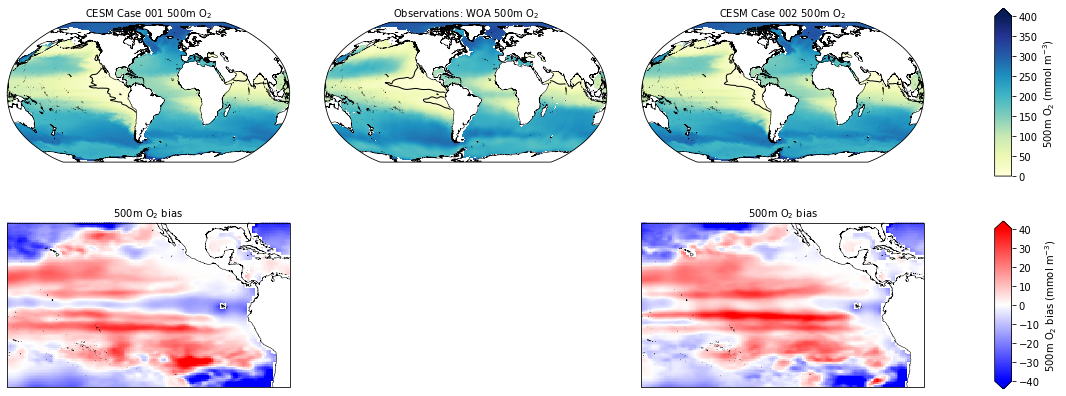

In [17]:
fig = plt.figure(figsize=(18,7))

gs = gridspec.GridSpec(nrows=3, ncols=5, width_ratios=(1, 1, 1, 0.005, 0.06),height_ratios=(1,0.001,1))

prj2 = ccrs.PlateCarree() 
prj = ccrs.Robinson(central_longitude=305.0)

ax_map_woa = plt.subplot(gs[0, 1], projection=prj)
ax_map_cesm1 = plt.subplot(gs[0, 0], projection=prj)
ax_map_cesm2 = plt.subplot(gs[0, 2], projection=prj)
ax_map_bias1 = plt.subplot(gs[2, 0], projection=prj2)
ax_map_bias2 = plt.subplot(gs[2, 2], projection=prj2)
ax_cb = plt.subplot(gs[0, 4])
ax_cb_diff = plt.subplot(gs[2, 4])

################# WOA O2
ax_map_woa.coastlines('10m',linewidth=0.5)
#ax_map_woa.set_extent([-180,180,-90,90])
ax_map_woa.set_title('Observations: WOA 500m O$_2$', fontsize=10)
ax_map_woa.contour(lons, lats, ds_woa['o_an'].isel(z_l=13),levels=[20],
                   colors='black',transform=ccrs.PlateCarree(),linewidths=1,zorder=2)
pc=ax_map_woa.pcolormesh(lons, lats, ds_woa['o_an'].isel(z_l=13), 
                  vmin=0, vmax=400, 
                  cmap='YlGnBu',
                 transform=ccrs.PlateCarree(), zorder=1)

################ CESM ctrl O2
ax_map_cesm1.coastlines('10m',linewidth=0.5)
ax_map_cesm1.set_title('CESM Case 001 500m O$_2$', fontsize=10)
ax_map_cesm1.contour(lons, lats,cesm_ann_ds_ctrl['O2'].isel(z_l=13),levels=[20],
                   colors='black',transform=ccrs.PlateCarree(),linewidths=1,zorder=2)
pc=ax_map_cesm1.pcolormesh(lons, lats, cesm_ann_ds_ctrl['O2'].isel(z_l=13), 
                  vmin=0, vmax=400, 
                  cmap='YlGnBu',
                 transform=ccrs.PlateCarree(),zorder=1)

################# CESM test O2
ax_map_cesm2.coastlines('10m',linewidth=0.5)
ax_map_cesm2.set_title('CESM Case 002 500m O$_2$', fontsize=10)
c=ax_map_cesm2.contour(lons, lats, cesm_ann_ds_test['O2'].isel(z_l=13),levels=[20],
                       colors='black',transform=ccrs.PlateCarree(),linewidths=1,zorder=2)
pc=ax_map_cesm2.pcolormesh(lons, lats, cesm_ann_ds_test['O2'].isel(z_l=13), 
                  vmin=0, vmax=400, 
                  cmap='YlGnBu',
                 transform=ccrs.PlateCarree(), zorder=1)

#---- DIFF panel O2 CTRL
ax_map_bias1.coastlines('10m',linewidth=0.5)
ax_map_bias1.set_extent([-175,-65,-20,20])
ax_map_bias1.set_title('500m O$_2$ bias', fontsize=10)
pc3=ax_map_bias1.pcolormesh(lons, lats, O2_diff_ctrl.isel(z_l=13), 
                  vmin=-40, vmax=40, 
                  cmap='bwr',transform=ccrs.PlateCarree())

#---- DIFF panel O2 TEST
ax_map_bias2.coastlines('10m',linewidth=0.5)
ax_map_bias2.set_extent([-175,-65,-20,20])
ax_map_bias2.set_title('500m O$_2$ bias', fontsize=10)
pc3=ax_map_bias2.pcolormesh(lons, lats, O2_diff_test.isel(z_l=13), 
                  vmin=-40, vmax=40, 
                  cmap='bwr', transform=ccrs.PlateCarree())


cbar1 = fig.colorbar(pc, cax=ax_cb ,extend='max',label='500m O$_2$ (mmol m$^{-3}$)')


cbar1 = fig.colorbar(pc3, cax=ax_cb_diff,extend='both',label='500m O$_2$ bias (mmol m$^{-3}$)')



# lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
# lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
# ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
# lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
# ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())
fig.savefig('/glade/work/kristenk/figs/O2_500m_maps.png', bbox_inches='tight', dpi=300, format='png');

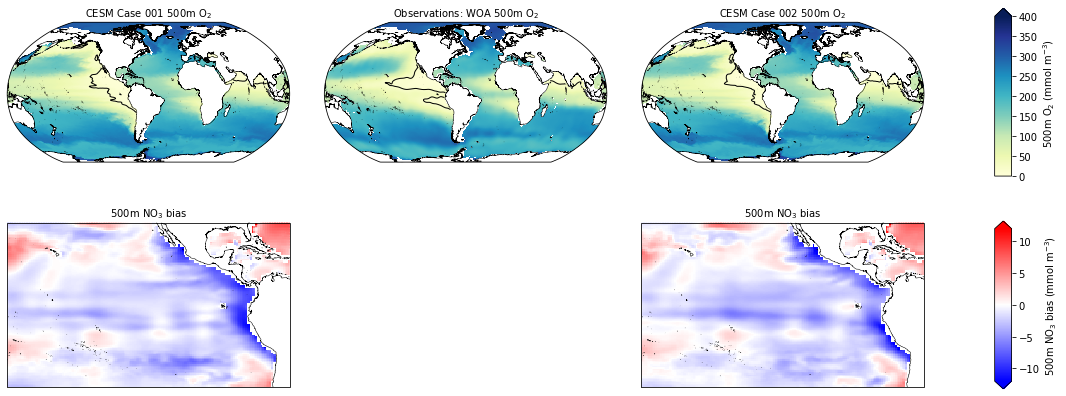

In [18]:
fig = plt.figure(figsize=(18,7))

gs = gridspec.GridSpec(nrows=3, ncols=5, width_ratios=(1, 1, 1, 0.005, 0.06),height_ratios=(1,0.001,1))

prj2 = ccrs.PlateCarree() 
prj = ccrs.Robinson(central_longitude=305.0)

ax_map_woa = plt.subplot(gs[0, 1], projection=prj)
ax_map_cesm1 = plt.subplot(gs[0, 0], projection=prj)
ax_map_cesm2 = plt.subplot(gs[0, 2], projection=prj)
ax_map_bias1 = plt.subplot(gs[2, 0], projection=prj2)
ax_map_bias2 = plt.subplot(gs[2, 2], projection=prj2)
ax_cb = plt.subplot(gs[0, 4])
ax_cb_diff = plt.subplot(gs[2, 4])

################# WOA O2
ax_map_woa.coastlines('10m',linewidth=0.5)
#ax_map_woa.set_extent([-180,180,-90,90])
ax_map_woa.set_title('Observations: WOA 500m O$_2$', fontsize=10)
ax_map_woa.contour(lons, lats, ds_woa['o_an'].isel(z_l=13),levels=[20],
                   colors='black',transform=ccrs.PlateCarree(),linewidths=1,zorder=2)
pc=ax_map_woa.pcolormesh(lons, lats, ds_woa['o_an'].isel(z_l=13), 
                  vmin=0, vmax=400, 
                  cmap='YlGnBu',
                 transform=ccrs.PlateCarree(), zorder=1)

################ CESM ctrl O2
ax_map_cesm1.coastlines('10m',linewidth=0.5)
ax_map_cesm1.set_title('CESM Case 001 500m O$_2$', fontsize=10)
ax_map_cesm1.contour(lons, lats,cesm_ann_ds_ctrl['O2'].isel(z_l=13),levels=[20],
                   colors='black',transform=ccrs.PlateCarree(),linewidths=1,zorder=2)
pc=ax_map_cesm1.pcolormesh(lons, lats, cesm_ann_ds_ctrl['O2'].isel(z_l=13), 
                  vmin=0, vmax=400, 
                  cmap='YlGnBu',
                 transform=ccrs.PlateCarree(),zorder=1)

################# CESM test O2
ax_map_cesm2.coastlines('10m',linewidth=0.5)
ax_map_cesm2.set_title('CESM Case 002 500m O$_2$', fontsize=10)
c=ax_map_cesm2.contour(lons, lats, cesm_ann_ds_test['O2'].isel(z_l=13),levels=[20],
                       colors='black',transform=ccrs.PlateCarree(),linewidths=1,zorder=2)
pc=ax_map_cesm2.pcolormesh(lons, lats, cesm_ann_ds_test['O2'].isel(z_l=13), 
                  vmin=0, vmax=400, 
                  cmap='YlGnBu',
                 transform=ccrs.PlateCarree(), zorder=1)

#---- DIFF panel O2 CTRL
ax_map_bias1.coastlines('10m',linewidth=0.5)
ax_map_bias1.set_extent([-175,-65,-20,20])
ax_map_bias1.set_title('500m NO$_3$ bias', fontsize=10)
pc3=ax_map_bias1.pcolormesh(lons, lats, NO3_diff_ctrl.isel(z_l=13), 
                  vmin=-12, vmax=12, 
                  cmap='bwr',transform=ccrs.PlateCarree())

#---- DIFF panel O2 TEST
ax_map_bias2.coastlines('10m',linewidth=0.5)
ax_map_bias2.set_extent([-175,-65,-20,20])
ax_map_bias2.set_title('500m NO$_3$ bias', fontsize=10)
pc3=ax_map_bias2.pcolormesh(lons, lats, NO3_diff_test.isel(z_l=13), 
                  vmin=-12, vmax=12, 
                  cmap='bwr', transform=ccrs.PlateCarree())


cbar1 = fig.colorbar(pc, cax=ax_cb ,extend='max',label='500m O$_2$ (mmol m$^{-3}$)')


cbar1 = fig.colorbar(pc3, cax=ax_cb_diff,extend='both',label='500m NO$_3$ bias (mmol m$^{-3}$)')



# lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
# lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
# ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

# lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
# lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
# ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())
fig.savefig('/glade/work/kristenk/figs/O2_500m_maps2.png', bbox_inches='tight', dpi=300, format='png');

In [19]:
import esmlab

In [20]:
depths = cesm_ann_ds_ctrl.z_l

In [21]:
rmse_global_ctrl = xr.Dataset({v: cesm_ann_ds_ctrl[v] for v in ['z_l']})

rmse_global_ctrl['NO3']=esmlab.statistics.weighted_rmsd(cesm_ann_ds_ctrl.NO3, ds_woa.n_an, dim=['yh', 'xh'], weights=area)
rmse_global_ctrl['O2']=esmlab.statistics.weighted_rmsd(cesm_ann_ds_ctrl.O2, ds_woa.o_an, dim=['yh', 'xh'], weights=area)

rmse_global_test = xr.Dataset({v: cesm_ann_ds_test[v] for v in ['z_l']})

rmse_global_test['NO3']=esmlab.statistics.weighted_rmsd(cesm_ann_ds_test.NO3, ds_woa.n_an, dim=['yh', 'xh'], weights=area)
rmse_global_test['O2']=esmlab.statistics.weighted_rmsd(cesm_ann_ds_test.O2, ds_woa.o_an, dim=['yh', 'xh'], weights=area)

In [22]:
rmse_eq_ctrl = xr.Dataset({v: cesm_ann_ds_ctrl[v] for v in ['z_l']})

rmse_eq_ctrl['NO3']=esmlab.statistics.weighted_rmsd(cesm_ann_ds_ctrl.NO3.where(lats<10).where(lats>-10), ds_woa.n_an.where(lats<10).where(lats>-10), dim=['yh', 'xh'], weights=area)
rmse_eq_ctrl['O2']=esmlab.statistics.weighted_rmsd(cesm_ann_ds_ctrl.O2.where(lats<10).where(lats>-10), ds_woa.o_an.where(lats<10).where(lats>-10), dim=['yh', 'xh'], weights=area)

rmse_eq_test = xr.Dataset({v: cesm_ann_ds_ctrl[v] for v in ['z_l']})

rmse_eq_test['NO3']=esmlab.statistics.weighted_rmsd(cesm_ann_ds_test.NO3.where(lats<10).where(lats>-10), ds_woa.n_an.where(lats<10).where(lats>-10), dim=['yh', 'xh'], weights=area)
rmse_eq_test['O2']=esmlab.statistics.weighted_rmsd(cesm_ann_ds_test.O2.where(lats<10).where(lats>-10), ds_woa.o_an.where(lats<10).where(lats>-10), dim=['yh', 'xh'], weights=area)

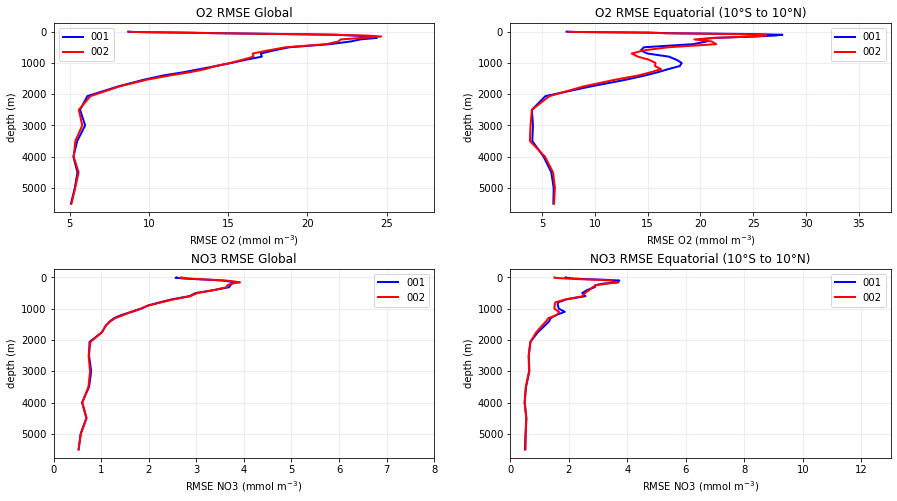

In [23]:
fig = plt.figure(figsize=(15,8))

#COLUMN 1  - ALK

ax = fig.add_subplot(2,2,1)
ax.set_title('O2 RMSE Global')
ax.plot(rmse_global_ctrl['O2'], depths, linewidth=2,color='blue',label='001')
ax.plot(rmse_global_test['O2'], depths, linewidth=2,color='red',label='002')
ax.legend()
ax.xaxis.grid(True, which='both',color='lavender')
ax.yaxis.grid(True, which='both',color='lavender');
ax.set(ylabel='depth (m)',xlabel='RMSE O2 (mmol m$^{-3}$)')
ax.set_xlim(4,28)
plt.gca().invert_yaxis()

ax = fig.add_subplot(2,2,3)
ax.set_title('NO3 RMSE Global')
ax.plot(rmse_global_ctrl['NO3'], depths, linewidth=2,color='blue',label='001')
ax.plot(rmse_global_test['NO3'], depths, linewidth=2,color='red',label='002')
ax.legend()
ax.xaxis.grid(True, which='both',color='lavender')
ax.yaxis.grid(True, which='both',color='lavender');
ax.set(ylabel='depth (m)',xlabel='RMSE NO3 (mmol m$^{-3}$)')
ax.set_xlim(0,8)
plt.gca().invert_yaxis()

ax = fig.add_subplot(2,2,2)
ax.set_title('O2 RMSE Equatorial (10°S to 10°N)')
ax.plot(rmse_eq_ctrl['O2'], depths, linewidth=2,color='blue',label='001')
ax.plot(rmse_eq_test['O2'], depths, linewidth=2,color='red',label='002')
ax.legend()
ax.xaxis.grid(True, which='both',color='lavender')
ax.yaxis.grid(True, which='both',color='lavender');
ax.set(ylabel='depth (m)',xlabel='RMSE O2 (mmol m$^{-3}$)')
ax.set_xlim(2,38)
plt.gca().invert_yaxis()

ax = fig.add_subplot(2,2,4)
ax.set_title('NO3 RMSE Equatorial (10°S to 10°N)')
ax.plot(rmse_eq_ctrl['NO3'], depths, linewidth=2,color='blue',label='001')
ax.plot(rmse_eq_test['NO3'], depths, linewidth=2,color='red',label='002')
ax.legend()
ax.xaxis.grid(True, which='both',color='lavender')
ax.yaxis.grid(True, which='both',color='lavender');
ax.set(ylabel='depth (m)',xlabel='RMSE NO3 (mmol m$^{-3}$)')
ax.set_xlim(0,13)
plt.gca().invert_yaxis()

fig.subplots_adjust(hspace=0.3)

### Define boxes

In [24]:
ones = np.full((ylen,xlen),1,dtype=int)
ones = xr.DataArray(ones,dims=('yh','xh'))
ones = ones.where(ds_grid.wet>0)


### Equatorial Pacific
box1_latmin = -10
box1_latmax = 10
box1_lonmin = -135.
box1_lonmax = -75.

### Equatorial Atlantic
box2_latmin = -10
box2_latmax = 10
box2_lonmin = -15
box2_lonmax = 15

reg_name_dict = {'box1' : 'Equatorial Pacific',
                 'box2' : 'Equatorial Atlantic' }

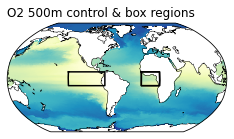

In [25]:
fig = plt.figure(figsize=(5,2))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('O2 500m control & box regions', fontsize=12,loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats,  cesm_ann_ds_ctrl.O2.isel(z_l=13))
pc=ax.pcolormesh(lon, lat, field, cmap='YlGnBu',
                 vmin=0,vmax=400,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())

ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree());

### Generate masks for these regions

In [26]:
mask1 = ones.where(lats<box1_latmax).where(lats>box1_latmin).where(lons_norm<box1_lonmax).where(lons_norm>box1_lonmin)
mask2 = ones.where(lats<box2_latmax).where(lats>box2_latmin).where(lons_norm<box2_lonmax).where(lons_norm>box2_lonmin)

### put them in a dictionary

mask_dict = {'mask1' : mask1, 
             'mask2' : mask2}

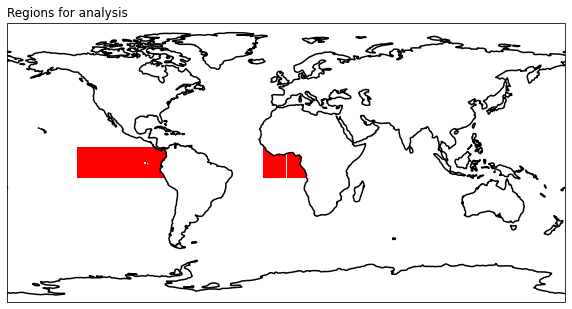

In [27]:
fig = plt.figure(figsize=(10,8))

from matplotlib.colors import ListedColormap
cmap = ListedColormap(name='allred', colors=['red'])

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.set_title('Regions for analysis', loc='left')

for reg in ['1','2']:

    pc1 = ax.pcolormesh(lons,lats,mask_dict['mask'+reg],
                    transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap(cmap,1),
                   vmin=0,vmax=1)

ax.coastlines('110m',linewidth=1.5)


### Make depth profiles 

In [28]:
depths = cesm_mon_ds_ctrl.z_l

In [29]:
area_depth = area.where(cesm_ann_ds_ctrl.O2 > -100).where(ds_woa['o_an'] > -100)

### Make annual mean values for 3-D variables

In [30]:
%%time

ts_annmean_dict_3d_test = {}
ts_annmean_dict_3d_ctrl = {}
ts_woa_dict_3d = {}


for reg in ['1','2']:

    print('doing region', reg)
    mask = mask_dict['mask'+reg]
    
    ts = xr.Dataset()
    for v in variables3d:
        
        masked_area = area_depth.where(mask==1)
        masked_fosi = cesm_ann_ds_ctrl[v].where(mask==1)
        ts[v] = (masked_fosi * masked_area).sum(dim=('xh','yh')) / masked_area.sum(dim=('xh','yh'))

    ts_annmean_dict_3d_ctrl['box'+reg] = ts.compute()
    
    ts = xr.Dataset()
    for v in variables3d:
        
        masked_area = area_depth.where(mask==1)
        masked_fosi = cesm_ann_ds_test[v].where(mask==1)
        ts[v] = (masked_fosi * masked_area).sum(dim=('xh','yh')) / masked_area.sum(dim=('xh','yh'))

    ts_annmean_dict_3d_test['box'+reg] = ts.compute()
    
    ts = xr.Dataset()
    for v in ['p_an','n_an','o_an','i_an']:
        
        masked_area = area_depth.where(mask==1)
        masked_var = ds_woa[v].where(mask==1)
        ts[v] = (masked_var * masked_area).sum(dim=('xh','yh')) / masked_area.sum(dim=('xh','yh'))

    ts_woa_dict_3d['box'+reg] = ts.compute()

doing region 1
doing region 2
CPU times: user 982 ms, sys: 215 ms, total: 1.2 s
Wall time: 1.25 s


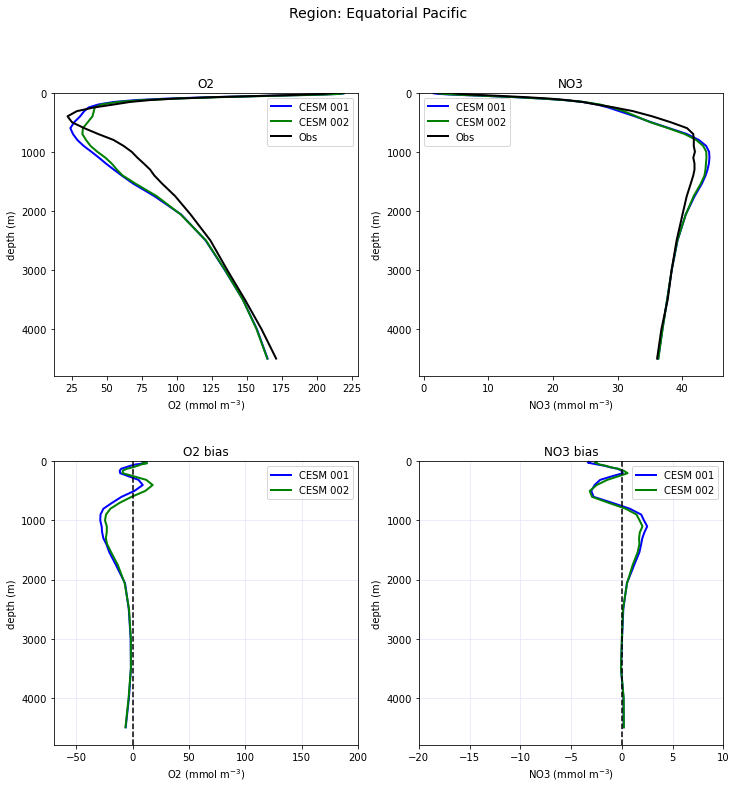

-----------------------------------------------------------------------------


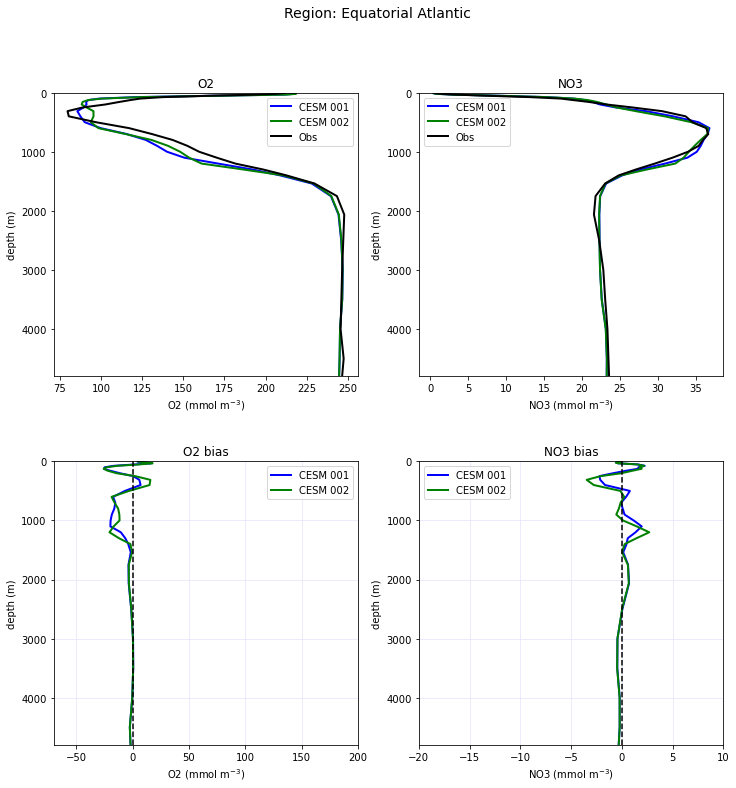

-----------------------------------------------------------------------------


In [31]:
for reg in ['1','2']:

    fig = plt.figure(figsize=(12,12))
    plt.suptitle('Region: ' + reg_name_dict['box'+reg],fontsize=14)

    ax = fig.add_subplot(2,2,2)
    ax.set_title('NO3')
    
    ax.plot(ts_annmean_dict_3d_ctrl['box'+reg]['NO3'], depths, 
                label='CESM 001', linewidth=2, color='blue')

    ax.plot(ts_annmean_dict_3d_test['box'+reg]['NO3'], depths, 
                label='CESM 002', linewidth=2, color='green')

    ax.plot(ts_woa_dict_3d['box'+reg]['n_an'], depths, 
                label='Obs', linewidth=2, color='black')
    
    ax.set_ylim(0,4800)
    ax.legend()
    ax.set(ylabel='depth (m)',xlabel= 'NO3 (mmol m$^{-3}$)')
    plt.gca().invert_yaxis()
        

    ax = fig.add_subplot(2,2,1)
    ax.set_title('O2')
    ax.plot(ts_annmean_dict_3d_ctrl['box'+reg]['O2'], depths, 
                label='CESM 001', linewidth=2, color='blue')
    
    ax.plot(ts_annmean_dict_3d_test['box'+reg]['O2'], depths, 
                label='CESM 002', linewidth=2, color='green')
    
    ax.plot(ts_woa_dict_3d['box'+reg]['o_an'], depths, 
                label='Obs', linewidth=2, color='black')
    
    ax.set_ylim(0,4800)
    ax.legend()
    ax.set(ylabel='depth (m)',xlabel= 'O2 (mmol m$^{-3}$)')
    plt.gca().invert_yaxis()
    
    ax = fig.add_subplot(2,2,4)
    ax.set_title('NO3 bias')
    ax.plot(ts_annmean_dict_3d_ctrl['box'+reg]['NO3'] - ts_woa_dict_3d['box'+reg]['n_an'], depths, 
                linewidth=2, color='blue',label='CESM 001')
    
    ax.plot(ts_annmean_dict_3d_test['box'+reg]['NO3'] - ts_woa_dict_3d['box'+reg]['n_an'], depths, 
                linewidth=2, color='green',label='CESM 002')
    ax.legend()
    ax.xaxis.grid(True, which='major',color='lavender')
    ax.yaxis.grid(False, which='major',color='lavender');
    ax.set_ylim(0,4800)
    ax.set_xlim(-20,10)
    ax.axvline(0,linestyle='--',color='black')
    ax.set(ylabel='depth (m)',xlabel= 'NO3 (mmol m$^{-3}$)')
    plt.gca().invert_yaxis()

    ax = fig.add_subplot(2,2,3)
    ax.set_title('O2 bias')
    ax.plot(ts_annmean_dict_3d_ctrl['box'+reg]['O2'] - ts_woa_dict_3d['box'+reg]['o_an'], depths, 
                linewidth=2, color='blue',label='CESM 001')

    ax.plot(ts_annmean_dict_3d_test['box'+reg]['O2'] - ts_woa_dict_3d['box'+reg]['o_an'], depths, 
                linewidth=2, color='green',label='CESM 002')
    ax.legend()
    ax.xaxis.grid(True, which='major',color='lavender')
    ax.yaxis.grid(False, which='major',color='lavender');
    ax.set_ylim(0,4800)
    ax.set_xlim(-70,200)
    ax.axvline(0,linestyle='--',color='black')
    ax.set(ylabel='depth (m)',xlabel= 'O2 (mmol m$^{-3}$)')
    plt.gca().invert_yaxis()

    fig.subplots_adjust(hspace=0.3)
    plt.show()
    fig.savefig('/glade/work/kristenk/figs/fig_O2profiles_'+reg+'.png', bbox_inches='tight', dpi=300, format='png');

    print('-----------------------------------------------------------------------------')
    

In [32]:
#cluster.close()